In [1]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
# Global Settings

# Directories
model_dataDir = 'DATA/MODELDATA/'
bench_dataDir = 'DATA/COINHISTDATA/'


# Time
START = 2021
END = 2022


# Helpers
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice


In [3]:
# Import Data

# Predictions
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Prices
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)
prices = model_mdf.loc[:,'Open':'Close']

# Benchmark
bench = pd.read_csv(bench_dataDir + 'bitcoin.csv')
bench.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
bench.set_index('Dates', inplace=True)
bench = bench.loc[:, ['Open']]
#bench = bench.Open
bench = bench.pct_change()
bench = bench.loc[str(START):]
bench.rename(columns = {'Open':'Bench'}, inplace = True)
print(bench.head())


               Bench
Dates               
2021-01-01  0.006286
2021-01-02  0.007291
2021-01-03  0.143942
2021-01-04 -0.010626
2021-01-05 -0.057505


In [4]:
#bench.info()

In [5]:
lr_predictions.tail()

actuals  predicted
Coin  Dates                          
zcash 2021-01-11  0.076817   0.045089
      2021-01-12  0.111461   0.053552
      2021-01-13 -0.039825   0.045640
      2021-01-14 -0.026371   0.057753
      2021-01-15  0.014359   0.055753

In [6]:
ridge_predictions.tail()

actuals  predicted    alpha
Coin  Dates                                   
zcash 2021-01-11  0.076817   0.001236  50000.0
      2021-01-12  0.111461   0.001332  50000.0
      2021-01-13 -0.039825   0.001400  50000.0
      2021-01-14 -0.026371   0.001476  50000.0
      2021-01-15  0.014359   0.001365  50000.0

In [7]:
lasso_predictions.tail()

actuals  predicted  alpha
Coin  Dates                                 
zcash 2021-01-11  0.076817        0.0   10.0
      2021-01-12  0.111461        0.0   10.0
      2021-01-13 -0.039825        0.0   10.0
      2021-01-14 -0.026371        0.0   10.0
      2021-01-15  0.014359        0.0   10.0

In [8]:
bench = bench.iloc[::-1]
bench.tail()

,Bench
Dates,
2021-01-05,-0.057505
2021-01-04,-0.010626
2021-01-03,0.143942
2021-01-02,0.007291
2021-01-01,0.006286


In [9]:
def filterdata(mdf,START):
    '''
    :param mdf: A MultiIndex DataFrame
    :param START: A start year as integer
    :return: MultiIndex Dataframe filtered by the above
    '''
    filtered = []
    for coin, new_df in mdf.groupby(level=1):
        new_df['Coin'] = new_df.index.get_level_values('Coin')
        new_df['Dates'] = new_df.index.get_level_values('Dates')
        new_df.set_index(new_df.index.get_level_values('Dates'), inplace=True)
        new_df = new_df.loc[str(START):]
        new_df.set_index(['Dates', 'Coin'], inplace=True)

        #print(new_df)
        filtered.append(new_df)

    mdf = pd.concat(filtered)
    mdf.sort_index(inplace=True)

    return mdf


In [10]:
prices = filterdata(prices,START) 
prices = prices.iloc[::-1]
prices = prices.swaplevel()
prices.tail()

,,Open,High,Low,Close
Coin,Dates,,,,
bitcoin-cash-sv,2021-01-01,164.193848,164.885755,162.473610,162.654212
bitcoin-cash,2021-01-01,348.743376,350.170700,336.502382,339.646272
bitcoin,2021-01-01,29169.454063,29460.978923,28974.371388,29342.220924
binancecoin,2021-01-01,37.758068,38.822250,37.165524,37.513959
basic-attention-token,2021-01-01,0.204632,0.210123,0.200790,0.204973


In [12]:
#prices = prices.swaplevel()

#prices = prices.Open.unstack('Coin')
#prices

In [13]:
def get_backtest_data(predictions, prices):
    """Combine regression model predictions
        with  OHLCV data"""
    
    best_alpha = predictions.groupby('alpha').apply(lambda x: spearmanr(x.actuals, x.predicted)[0]).idxmax()
    predictions = predictions[predictions.alpha == best_alpha]
    tickers = predictions.index.get_level_values('Coin').unique()
    
    start = predictions.index.get_level_values('Dates').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('Dates').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    idx = pd.IndexSlice
    #prices = prices.sort_index().loc[idx[tickers, start:stop], :]
    predictions = predictions.loc[predictions.alpha == best_alpha, ['predicted']]

    print(predictions.head())
    print('-----------------')
    prices = prices.sort_index()
    print(prices.head())
    #prices['predicted'] = predictions['predicted']
    #mdf = prices
    mdf = predictions.join(prices, how='right')
    
    return mdf


data = get_backtest_data(lasso_predictions,prices)
print(data.info())

                                  predicted
Coin                  Dates                
basic-attention-token 2022-01-01  -0.004723
                      2022-01-02  -0.006037
                      2022-01-03  -0.010940
                      2022-01-04  -0.014215
                      2022-01-05  -0.010628
-----------------
                                      Open      High       Low     Close
Coin                  Dates                                             
basic-attention-token 2021-01-01  0.204632  0.210123  0.200790  0.204973
                      2021-01-02  0.205343  0.206904  0.202771  0.202771
                      2021-01-03  0.204712  0.228518  0.201192  0.228518
                      2021-01-04  0.226148  0.229984  0.208869  0.218853
                      2021-01-05  0.223847  0.236860  0.218637  0.233518
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15678 entries, ('basic-attention-token', Timestamp('2021-01-01 00:00:00')) to ('zcash', Timestamp('2022-02-06 00:

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [14]:
#data['predicted'].nan().sum()

In [15]:
data.head(100)

predicted      Open      High       Low  \
Coin                  Dates                                                 
basic-attention-token 2021-01-01        NaN  0.204632  0.210123  0.200790   
                      2021-01-02        NaN  0.205343  0.206904  0.202771   
                      2021-01-03        NaN  0.204712  0.228518  0.201192   
                      2021-01-04        NaN  0.226148  0.229984  0.208869   
                      2021-01-05        NaN  0.223847  0.236860  0.218637   
...                                     ...       ...       ...       ...   
                      2021-04-06  -0.026510  1.217284  1.328257  1.204943   
                      2021-04-07  -0.015043  1.318859  1.363368  1.187444   
                      2021-04-08  -0.030624  1.213082  1.309196  1.212461   
                      2021-04-09  -0.047763  1.292872  1.623255  1.272518   
                      2021-04-10  -0.008854  1.567240  1.567240  1.400888   

                                     Close  
Coin                  Dates                 
basic-attention-token 2021-01-01  0.204973  
                      2021-01-02  0.202771  
                      2021-01-03  0.228518  
                      2021-01-04  0.218853  
                      2021-01-05  0.233518  
...                                    ...  
                      2021-04-06  1.328257  
                      2021-04-07  1.203097  
                      2021-04-08  1.298953  
                      2021-04-09  1.599974  
                      2021-04-10  1.461746  

[100 rows x 5 columns]

In [17]:
#data = data.swaplevel()
data.tail(100)

predicted        Open        High         Low       Close
Coin  Dates                                                                
zcash 2021-10-30   0.008110  161.229360  167.408880  152.245126  167.408880
      2021-10-31   0.006937  165.113795  181.449326  165.113795  165.456107
      2021-11-01   0.089484  162.077768  171.888648  162.077768  170.479628
      2021-11-02   0.089159  175.960965  179.141434  167.951842  168.971586
      2021-11-03   0.093449  167.900492  169.007155  163.271380  165.962265
...                     ...         ...         ...         ...         ...
      2022-02-02        NaN  100.509081  103.084153   98.243410   98.243410
      2022-02-03        NaN   98.182877  100.833935   95.995052  100.833935
      2022-02-04        NaN   99.948187  114.882213   99.948187  114.882213
      2022-02-05        NaN  115.028496  122.081184  114.873152  121.223630
      2022-02-06        NaN  124.280985  124.993579  121.797601  124.907266

[100 rows x 5 columns]

In [18]:
# Daily returns for all the coins in the dataset for the target time period
daily_returns = data.Open.unstack('Coin').sort_index().pct_change()
daily_returns.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 402 entries, 2021-01-01 to 2022-02-06
Columns: 39 entries, basic-attention-token to zcash
dtypes: float64(39)
memory usage: 125.6 KB


In [19]:
#daily_returns.head()

In [20]:
# Compute forward returns
fwd_returns = daily_returns.shift(-1)
fwd_returns.head()

Coin,basic-attention-token,binancecoin,bitcoin,bitcoin-cash,bitcoin-cash-sv,bittorrent-old,cardano,celsius-degree-token,chainlink,cosmos,...,nexo,okb,quant-network,ripple,stellar,tezos,theta-token,tron,vechain,zcash
Dates,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.003475,-0.006743,0.007291,-0.025898,-0.005234,0.029659,-0.043780,0.011154,0.025638,-0.063326,...,0.043084,0.067171,0.008093,-0.023738,-0.011542,-0.012748,0.096725,-0.005101,-0.027442,-0.111155
2021-01-02,-0.003071,0.019959,0.143942,0.069893,0.005496,0.050134,0.021336,0.099548,0.037477,-0.053344,...,0.176303,-0.125566,0.105812,-0.039154,-0.035475,-0.003978,0.120387,0.015110,0.055211,0.008393
2021-01-03,0.104711,0.085229,-0.010626,0.192649,0.103303,0.038549,0.270448,0.058503,0.193357,0.117932,...,-0.062536,-0.028166,-0.053919,0.060643,0.159872,0.125379,-0.069950,0.124874,0.284309,0.066713
2021-01-04,-0.010172,-0.040989,-0.057505,-0.070895,-0.094994,-0.092920,-0.044738,-0.087211,-0.075955,-0.040578,...,-0.047960,-0.093309,-0.054960,-0.034652,0.067359,-0.021422,-0.057305,-0.088787,-0.065849,-0.065961
2021-01-05,0.034976,0.030723,0.127055,0.065019,0.037234,0.036540,0.239335,0.036984,0.099300,0.039602,...,0.001646,0.026853,0.155464,-0.011064,0.333284,0.089238,0.072617,0.014257,0.202940,0.039411


In [21]:
# Isolate the predictions
predictions = data.predicted.unstack('Coin')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 402 entries, 2021-01-01 to 2022-02-06
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   basic-attention-token  364 non-null    float64
 1   binancecoin            364 non-null    float64
 2   bitcoin                364 non-null    float64
 3   bitcoin-cash           364 non-null    float64
 4   bitcoin-cash-sv        364 non-null    float64
 5   bittorrent-old         364 non-null    float64
 6   cardano                364 non-null    float64
 7   celsius-degree-token   364 non-null    float64
 8   chainlink              364 non-null    float64
 9   cosmos                 364 non-null    float64
 10  crypto-com-chain       364 non-null    float64
 11  dash                   364 non-null    float64
 12  decentraland           364 non-null    float64
 13  dogecoin               364 non-null    float64
 14  enjincoin              364 non-null    

In [22]:
#predictions.head(50)

In [23]:
# VECTORIZED BACKTEST

# Set the number of long and short positions
N_LONG = N_SHORT = 20

# Get the trading signals from the model predictions
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))


# Compute the portfolio returns for the backtest
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

In [24]:
#strategy.join(bench).head(100)

In [25]:
#bench.index.dtype

In [26]:
#bench.head(100)

In [27]:
#strategy.index.dtype

In [28]:
#strategy.head(100)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


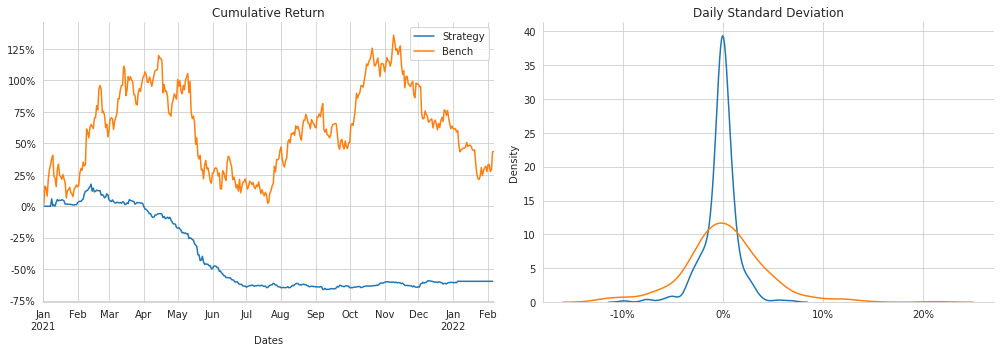

In [29]:
# Results
bench.index = pd.to_datetime(bench.index)
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(bench).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(bench, ax=axes[1], hist=False, label='BTC')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [ ]:
# EVENT-DRIVEN BACKTEST with Backtestester